<a href="https://colab.research.google.com/github/mgiorgi13/brain_tumor_classifier/blob/mattia/CNN_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In this paragraph, we have imported the necessary libraries to create the CNN. TensorFlow and Keras are the main frameworks that we will use to create the convolutional neural network. Additionally, we have imported other useful libraries such as OpenCV (cv2) for image preprocessing, PIL for image manipulation, and Matplotlib for image visualization.

In [1]:
import pickle
from keras.models import load_model
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate, BatchNormalization
import os
import glob
import shutil
from sklearn.utils import shuffle
import zipfile
import cv2
import imutils
from google.colab.patches import cv2_imshow
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import image_dataset_from_directory
from PIL import Image
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn import metrics

In [2]:
dataset_path = "/content/drive/MyDrive/BrainTumorDataset"

# **Google Drive connection**

Necessary to run the classifier

# **Utilities**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from itertools import cycle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,roc_curve, auc, roc_auc_score

dataset_path = "/content/drive/MyDrive/BrainTumorDataset"

# Percorso della cartella "unified" che contiene le sottocartelle delle classi
base_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Unified"

# Definisci i percorsi per il set di test, di validazione e di addestramento
test_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Test"
val_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Validation"
train_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Train"

def set_seed ():
	''' 
	set_seed is used to obtain reproducible results using keras during the development phase
	'''
	seed = 10
	# The below is necessary for reproducible results of certain Python hash-based operations.
	os.environ["PYTHONHASHSEED"]="0"
	# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
	np.random.seed(seed)
	# The below is necessary for starting core Python generated random numbers in a well-defined state.
	rn.seed(seed)
	# The below tf.random.set_seed will make x number generation in TensorFlow have a well-defined initial state.
	tf.random.set_seed(seed)     

# Definisci le dimensioni delle immagini
image_size = 250
batch_size = 32

# Crea un oggetto ImageDataGenerator per il preprocessing delle immagini
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Carica le immagini dal set di addestramento
train_generator = data_generator.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Carica le immagini dal set di test
test_generator = data_generator.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Carica le immagini dal set di validazione
val_generator = data_generator.flow_from_directory(
    val_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)
     

def show_training_and_validation_performance(history):
	'''
	show_training_and_validation_performance is used to plot the performances during the training phase
	:param history: object in which are recorded all the events
	'''
	acc = history.history['accuracy']
	val_acc = history.history['val_accuracy']
	loss = history.history['loss']
	val_loss = history.history['val_loss']

	epochs = range(len(acc))

	plt.plot(epochs, acc, 'bo', label='Training accuracy')
	plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
	plt.title('Training and validation accuracy')
	plt.legend()

	plt.figure()

	plt.plot(epochs, loss, 'bo', label='Training loss')
	plt.plot(epochs, val_loss, 'b', label='Validation loss')
	plt.title('Training and validation loss')
	plt.legend()

	plt.show()

def compile_model (model, optimizer='adam', learning_rate = 0.001):
	'''
	compile_model is used to compile the current model
	:param model: model to compile
	:param optimizer: optimizer to be used
	:param learning_rate: learning rate parameter for the optimizer
	'''
	if optimizer == 'adam':
		model.compile(loss="categorical_crossentropy",
		optimizer=optimizers.Adam(learning_rate=learning_rate),
		metrics=["accuracy"])
	elif optimizer == 'rmsprop':
		model.compile(loss="categorical_crossentropy",
					optimizer = optimizers.RMSprop(learning_rate=learning_rate),
					metrics=['accuracy'])
	model.summary()

def run_model (model, model_name, epochs = 100, patience=5, monitor='val_loss'):
	'''
	run_model is used to run the current mode
	:param model: model to run
	:param model_name: name given to save the model
	:param epochs: how many epochs to do
	:param patience: patience value for Early Stopping
	:param monitor: what to monitor for Early Stopping and Model Checkpoint
	'''
	# local save path for the models
	save_path = dataset_path + '/' + model_name + '.h5'
	callbacks_list = [
					keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
					keras.callbacks.ModelCheckpoint(
						filepath = save_path,
						monitor=monitor,
						verbose=1,
						save_best_only=True)
					]
	history = model.fit(train_generator,
						epochs=epochs,
						validation_data=val_generator,
						callbacks=callbacks_list)
	# save on Drive only the best model
	show_training_and_validation_performance(history)

def plot_roc_curve(y_true, y_pred, n_classes, class_labels):

    # Converti le etichette di classe in formato binario
    lb = LabelBinarizer()
    y_true_binary = lb.fit_transform(y_true)

    # Calcola i tassi di FPR e TPR per ogni classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_true_binary[:, i], y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    plt.figure()
    colors = ['blue', 'red', 'green', 'orange']  # Colori per le diverse classi

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, label='ROC curve {0} ({1:0.2f}%)'.format(class_labels[i], roc_auc[i]*100))

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

def evaluate_model (model, test_dataset):
	'''
	evaluate_model is used to plot some statistics about the performance on the test set
	:param model: model to consider
	'''
	labels_d= ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

	# get predictions
	y_score = model.predict(test_generator)
	# convert predictions to classes
	y_pred = np.argmax(y_score, axis=-1)
	# get true classes
	y_true = test_generator.classes
	# extract class labels
	class_labels = list(test_generator.class_indices.keys())
	
	print("Classification report: ")
	print(metrics.classification_report(y_true, y_pred, target_names=class_labels,digits = 4))
	# create and show confusion matrix and roc
	metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred,display_labels=class_labels, xticks_rotation='vertical')
	plot_roc_curve(y_true, y_score, 4, class_labels)
 
set_seed()


Found 4520 images belonging to 4 classes.
Found 652 images belonging to 4 classes.
Found 652 images belonging to 4 classes.


In [3]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Load Dataset**

In [4]:
# Definisci i percorsi per il set di test, di validazione e di addestramento
test_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Test"
val_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Validation"
train_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Train"

In [5]:
from keras.preprocessing.image import ImageDataGenerator

# Definisci le dimensioni delle immagini
image_size = 250
batch_size = 32

# Crea un oggetto ImageDataGenerator per il preprocessing delle immagini
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Carica le immagini dal set di addestramento
train_generator = data_generator.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Carica le immagini dal set di test
test_generator = data_generator.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Carica le immagini dal set di validazione
val_generator = data_generator.flow_from_directory(
    val_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 4520 images belonging to 4 classes.
Found 652 images belonging to 4 classes.
Found 652 images belonging to 4 classes.


In [6]:
class_indices = test_generator.class_indices
num_samples = test_generator.samples

class_counts = {class_label: 0 for class_label in class_indices}

# Conta i campioni per ogni classe
for filename in val_generator.filenames:
    class_label = filename.split('/')[0]  # Ottieni l'etichetta della classe dal percorso del file
    class_counts[class_label] += 1

# Calcola la percentuale di campioni per ogni classe
class_balances = {class_label: count / num_samples for class_label, count in class_counts.items()}

print("Bilanciamento delle classi nel set di test:")
for class_label, balance in class_balances.items():
    print(f"Classe {class_label}: {balance * 100}%")


Bilanciamento delle classi nel set di test:
Classe glioma_tumor: 28.37423312883436%
Classe meningioma_tumor: 28.680981595092025%
Classe no_tumor: 15.337423312883436%
Classe pituitary_tumor: 27.607361963190186%


# **STATS**

In [7]:
def save_history(name, history):
  with open(dataset_path + name, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

def load_history(path):
  with open(path, "rb") as file_pi:
    history = pickle.load(file_pi)
  return history

def train_val_evaluation_plot(history):
  acc = history['accuracy']
  val_acc = history['val_accuracy']
  loss = history['loss']
  val_loss = history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def run_test(model):
  m = load_model(dataset_path + model)
  # Ottenere le previsioni del modello per i dati di test
  y_pred = m.predict(test_generator)
  # Convertire le previsioni in classi (etichette) utilizzando la funzione argmax di NumPy
  y_pred_classes = np.argmax(y_pred, axis=1)
  # Convertire le etichette reali dei dati di test in un array di interi
  y_true = test_generator.classes
  return y_true, y_pred_classes

def stats(model, history):
  m = load_model(dataset_path + model)
  train_val_evaluation_plot(history)
  y_true, y_pred_classes = run_test(model)
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred_classes,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred_classes)

Se il modello riesce ad apprendere correttamente, si dovrebbe osservare un andamento decrescente della loss e un andamento crescente dell'accuracy nel training set. Tuttavia, se la rete ha una capacità eccessiva rispetto al problema da risolvere, può incorrere in overfitting: in tal caso si ha un abbassamento della loss e un aumento dell'accuracy sul training set, ma un peggioramento delle performance sulla validation set (ovvero un aumento della validation loss e un abbassamento della validation accuracy).

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from itertools import cycle



# Calcolare le curve ROC per ogni classe
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = test_generator.num_classes

y_true_categorical = to_categorical(y_true, num_classes=n_classes)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_categorical[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcolare la media delle curve ROC micro e macro
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_categorical.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Calcolare il valore medio delle AUC macro
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot della curva ROC per ogni classe
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='ROC curve (micro-average) (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=2)
plt.plot(fpr["macro"], tpr["macro"],
         label='ROC curve (macro-average) (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

# Plot della linea diagonale (classificatore casuale)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Impostare limiti e etichette del grafico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()


NameError: ignored

FIN QUI FUNZIONA

## TO DO

## VERSIONE VECCHIA

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(4), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multiclass')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=['0', '1'])
disp.plot()
plt.show()

# classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

confonde meningioma con il glioma

# **CNN from scratch**

Se stai aggiungendo 3 layer di convoluzione e Max Pooling alla tua CNN, hai alcune opzioni per le dimensioni delle finestre dei layer di Max Pooling. Puoi lasciare le dimensioni fisse a 3x3 per tutti i layer, oppure puoi renderle incrementali, aumentandole passo dopo passo. Entrambi gli approcci hanno i loro pro e contro.

Dimensioni fisse a 3x3 per tutti i layer di Max Pooling: Questo approccio mantiene le dimensioni delle finestre di pooling costanti in tutti i layer. Puoi utilizzare una dimensione di 3x3 per tutti e tre i layer di Max Pooling. Questo offre uniformità nell'estrazione delle caratteristiche e riduce il rischio di perdita di informazioni in modo significativo. Tuttavia, potresti incorrere in una riduzione delle dimensioni spaziali più rapida rispetto a un'alternativa incrementale.

Dimensioni incrementali delle finestre di Max Pooling: In alternativa, puoi aumentare le dimensioni delle finestre di pooling man mano che procedi attraverso i layer. Ad esempio, potresti utilizzare una finestra 2x2 per il primo layer di Max Pooling, una finestra 3x3 per il secondo e una finestra 4x4 per il terzo. Questo approccio consente di catturare caratteristiche a diverse scale durante la progressione attraverso la rete. Può essere particolarmente utile se hai immagini di grandi dimensioni o se desideri enfatizzare caratteristiche più ampie a livelli superiori della rete.

La scelta tra le due opzioni dipende dal tuo problema specifico, dalle dimensioni delle immagini di input, dalla complessità delle caratteristiche che desideri rilevare e dal trade-off tra dimensione dell'output, complessità computazionale e informazioni mantenute.

Tuttavia, ricorda che aumentare le dimensioni delle finestre di pooling può portare a una riduzione più rapida delle dimensioni spaziali dell'output e potrebbe comportare una perdita di dettagli più significativa. Pertanto, è consigliabile eseguire esperimenti e valutare le prestazioni del tuo modello per determinare quale approccio funzioni meglio nel contesto del tuo problema specifico.

## Exp 1

First CNN model with **one convolutional layer** and **one max pooling layer** at the biginning.

Than **one flatten layer** and **one dense layer** with 4 units (one for each class) and softmax activation function.

In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

compile_model(model)

run_model(model, 'cnn_from_scratch_exp1')

evaluate_model(model,test_generator)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 500000)            0         
                                                                 
 dense (Dense)               (None, 4)                 2000004   
                                                                 
Total params: 2,000,900
Trainable params: 2,000,900
Non-trainable params: 0
_________________________________________________________________


## Exp 2

Second CNN model with **three convolutional layers** and **three max pooling layers** at the biginning.

Than **one flatten layer** and **one dense layer** with 256 units and softmax activation function.

We add a **dropout layer** with 0.5 probability to avoid overfitting.

At the end we add a **dense layer** with 4 units (one for each class) and softmax activation function.

In [13]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((3, 3)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((4, 4)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

compile_model(model)

run_model(model, 'cnn_from_scratch_exp2')

evaluate_model(model,test_generator)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 250, 250, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 41, 41, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 10, 128)     

## Exp 3

Third CNN model with **four convolutional layers** and **four max pooling layers** at the biginning.

Each of the max pooling layer have a **different pool size**.

Than **one flatten layer** and **one dense layer** with 256 units and softmax activation function.

We add a **dropout layer** with 0.5 probability to avoid overfitting.

At the end we add a **dense layer** with 4 units (one for each class) and softmax activation function. 

In [18]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((3, 3)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((4, 4)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((5, 5)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

compile_model(model)

run_model(model, 'cnn_from_scratch_exp3')

evaluate_model(model,test_generator)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 250, 250, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 41, 41, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 10, 10, 128)     

##Exp 8

Eighth CNN model with four convolutional layers and four max pooling layers at the biginning.

Now each of the max pooling layer have a different pool size.

Than one flatten layer and one dense layer with 512 units and softmax activation function.

We add a dropout layer with 0.5 probability to avoid overfitting.

At the end we add a dense layer with 4 units (one for each class) and softmax activation function.

In [23]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((3, 3)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((4, 4)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((5, 5)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 250, 250, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 41, 41, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 10, 10, 128)     

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint(filepath=dataset_path + '/modello_cnn_exp8.h5', monitor='val_loss', save_best_only=True)

callbacks_list = [reduce_lr, checkpoint]
history = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=callbacks_list)

Epoch 1/20
142/142 [==============================] - 36s 238ms/step - loss: 1.1596 - accuracy: 0.4697 - val_loss: 0.8826 - val_accuracy: 0.6212 - lr: 0.0010
Epoch 2/20
142/142 [==============================] - 35s 248ms/step - loss: 0.7838 - accuracy: 0.6909 - val_loss: 0.6178 - val_accuracy: 0.7439 - lr: 0.0010
Epoch 3/20
142/142 [==============================] - 34s 241ms/step - loss: 0.6234 - accuracy: 0.7611 - val_loss: 0.5528 - val_accuracy: 0.7791 - lr: 0.0010
Epoch 4/20
142/142 [==============================] - 35s 247ms/step - loss: 0.5098 - accuracy: 0.8100 - val_loss: 0.4706 - val_accuracy: 0.8129 - lr: 0.0010
Epoch 5/20
142/142 [==============================] - 34s 240ms/step - loss: 0.4201 - accuracy: 0.8354 - val_loss: 0.4603 - val_accuracy: 0.8113 - lr: 0.0010
Epoch 6/20
142/142 [==============================] - 36s 250ms/step - loss: 0.3347 - accuracy: 0.8686 - val_loss: 0.4567 - val_accuracy: 0.8298 - lr: 0.0010
Epoch 7/20
142/142 [==============================] 

In [26]:
save_history('/history_cnn_exp8.h5',history)

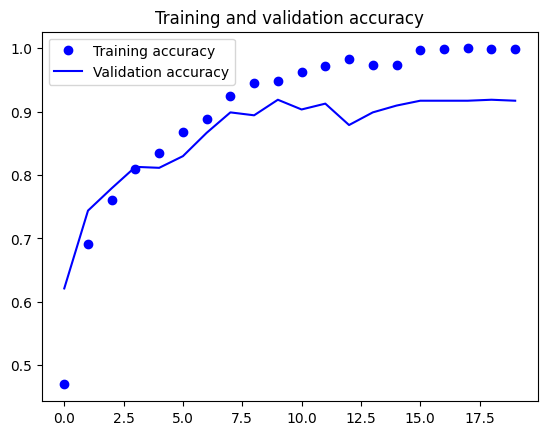

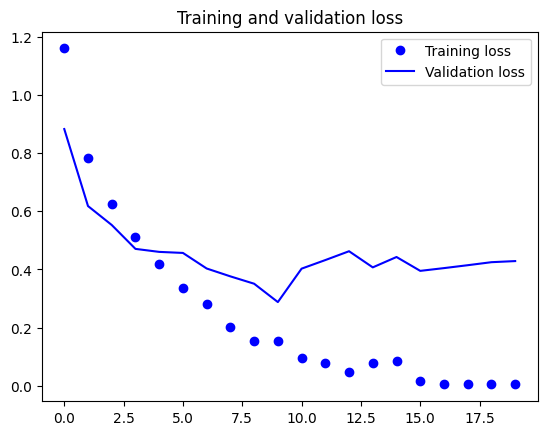

21/21 [==============================] - 4s 203ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8966    0.8432    0.8691       185
           1     0.7970    0.8396    0.8177       187
           2     0.8440    0.9200    0.8804       100
           3     0.9709    0.9278    0.9489       180

    accuracy                         0.8773       652
   macro avg     0.8771    0.8826    0.8790       652
weighted avg     0.8805    0.8773    0.8781       652



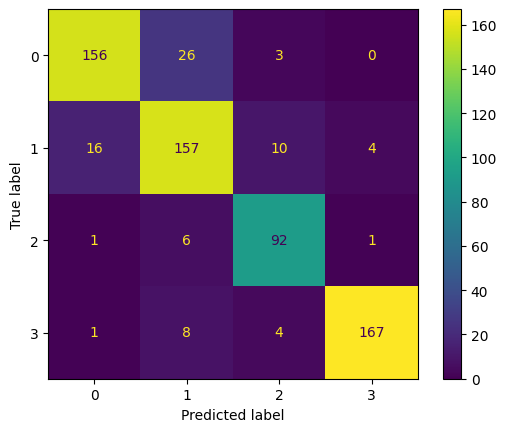

In [27]:
stats("/modello_cnn_exp8.h5", load_history(dataset_path + '/history_cnn_exp8.h5'))

## Exp 9

Ninth CNN model with 3 convolutional layers and 3 max pooling layer at the biginning.


Now each of the max pooling layer have a different pool size.

Than one flatten layer and one dense layer with 512 units and softmax activation function.

Than one other dense layer with 256 units and softmax activation function.

We add a dropout layer with 0.5 probability to avoid overfitting.

At the end we add a dense layer with 4 units (one for each class) and softmax activation function.

In [28]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((3, 3)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((4, 4)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((5, 5)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

compile_model(model)

run_model(model, 'cnn_from_scratch_exp9')

evaluate_model(model,test_generator)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 250, 250, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 41, 41, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 10, 10, 128)     

## initial model

In [33]:
# Definire un modello sequenziale di Keras
model = Sequential()

# Aggiungere un layer convoluzionale con 32 filtri, dimensione del kernel di 3x3, funzione di attivazione ReLU e padding "same"
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)))

# Aggiungere un layer di max pooling con dimensione 2x2
model.add(MaxPooling2D((2, 2)))

# Aggiungere un altro layer convoluzionale con 64 filtri, dimensione del kernel di 3x3, funzione di attivazione ReLU e padding "same"
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

# Aggiungere un altro layer di max pooling con dimensione 2x2
model.add(MaxPooling2D((2, 2)))

# Aggiungere un altro layer convoluzionale con 128 filtri, dimensione del kernel di 3x3, funzione di attivazione ReLU e padding "same"
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

# Aggiungere un altro layer di max pooling con dimensione 2x2
model.add(MaxPooling2D((2, 2)))

# Aggiungere un layer di appiattimento per convertire l'output del layer precedente in un vettore unidimensionale
model.add(Flatten())

# Aggiungere un layer completamente connesso con 512 unità e funzione di attivazione ReLU
model.add(Dense(512, activation='relu'))

# Aggiungere un layer di dropout con una percentuale di dropout di 0,5
model.add(Dropout(0.5))

# Aggiungere un altro layer completamente connesso con 4 unità (una per ogni classe) e funzione di attivazione softmax
model.add(Dense(4, activation='softmax'))

compile_model(model)

run_model(model, 'cnn_from_scratch_initial_model')

evaluate_model(model,test_generator)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 250, 250, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 62, 62, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 31, 31, 128)     